# Tutorial: GEPA for Structured Information Extraction for Enterprise Tasks

See the original DSPy version [here](https://dspy.ai/tutorials/gepa_facilitysupportanalyzer/)

This notebook reproduces the DSPy version using our custom adapter. This allows us to use pydantic-ai's structured output support directly with the canonical GEPA api. 

The DSPy version relies on three separate model calls to produce the output attributes of `urgency`, `sentiment`, and list of `categories`. Here, we leverage a single output schema and thus one api call prediction.

In [1]:
import json
import os
import sys
from typing import Literal

from pydantic import BaseModel, Field

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
from src.gepadantic.scaffold import GepaConfig, run_optimization_pipeline

In this tutorial, we'll explore a three-part task for structured information extraction and classification using the [Facility Support Analyzer](https://github.com/meta-llama/prompt-ops/tree/main/use-cases/facility-support-analyzer) dataset released by Meta. Given an email or message sent in an enterprise setting related to facility maintenance or support requests, the goal is to extract its urgency, assess the sentiment, and identify all relevant service request categories.

In [4]:
import requests


url = "https://raw.githubusercontent.com/meta-llama/llama-prompt-ops/refs/heads/main/use-cases/facility-support-analyzer/dataset.json"
dataset = json.loads(requests.get(url).text)

In [ ]:
dataset[0]['fields']['input']

'Subject: Urgent Assistance Required for Specialized Cleaning Services\n\nDear ProCare Facility Solutions Support Team,\n\nI hope this message finds you well. My name is [Sender], and my family and I have been availing your services for our home for the past year. We have always appreciated the high standards and professionalism your team brings to maintaining our living environment.\n\nHowever, we are currently facing an urgent issue that requires immediate attention. We recently hosted a large gathering at our home, and despite our best efforts, there are several areas that now require specialized cleaning. Specifically, we need deep cleaning for our carpets and upholstery, as well as thorough window washing. The situation is quite pressing as we have more guests arriving soon, and we want to ensure our home is in pristine condition to welcome them.\n\nWe have tried some basic cleaning ourselves, but the results have not been satisfactory. Given the high standards we have come to exp

In [6]:
dataset[0]['answer']

'{"categories": {"routine_maintenance_requests": false, "customer_feedback_and_complaints": false, "training_and_support_requests": false, "quality_and_safety_concerns": false, "sustainability_and_environmental_practices": false, "cleaning_services_scheduling": false, "specialized_cleaning_services": true, "emergency_repair_services": false, "facility_management_issues": false, "general_inquiries": false}, "sentiment": "neutral", "urgency": "high"}'

## Define input model

In [45]:
class EmailInput(BaseModel):
    """Input model for email classification."""
    
    input: str = Field(description="The email content to classify")


In [8]:
from typing import Any

from gepadantic.schema import InputModelT, DataInstWithInput


def init_dataset(
    input_data: list[dict[str, Any]],
) -> list[DataInstWithInput[InputModelT]]:
    """Load data from a list of dicts and convert to DataInstWithInput instances."""
    
    dataset: list[DataInstWithInput[InputModelT]] = []

    for idx, item in enumerate(input_data):
        if not isinstance(item, dict):
            raise ValueError(f"Item at index {idx} is not a dict: {type(item)}")

        # Convert dict to input model using user-provided mapper
        try:
            input_instance = EmailInput(input=item['fields']['input'])
        except Exception as e:
            raise ValueError(f"Error mapping item {idx} to input model: {e}") from e

        # Extract metadata
        metadata = {
            'expected_output': json.loads(item['answer']),
        }

        case_id = f"item-{idx}"

        # Create DataInstWithInput
        data_inst = DataInstWithInput[InputModelT](
            input=input_instance,
            message_history=None,
            metadata=metadata,
            case_id=case_id,
        )
        dataset.append(data_inst)

    return dataset

In [9]:
prepared_dataset = init_dataset(dataset)

In [10]:
prepared_dataset[0].__dict__

{'input': EmailInput(input='Subject: Urgent Assistance Required for Specialized Cleaning Services\n\nDear ProCare Facility Solutions Support Team,\n\nI hope this message finds you well. My name is [Sender], and my family and I have been availing your services for our home for the past year. We have always appreciated the high standards and professionalism your team brings to maintaining our living environment.\n\nHowever, we are currently facing an urgent issue that requires immediate attention. We recently hosted a large gathering at our home, and despite our best efforts, there are several areas that now require specialized cleaning. Specifically, we need deep cleaning for our carpets and upholstery, as well as thorough window washing. The situation is quite pressing as we have more guests arriving soon, and we want to ensure our home is in pristine condition to welcome them.\n\nWe have tried some basic cleaning ourselves, but the results have not been satisfactory. Given the high st

In [11]:
import random

random.Random(42).shuffle(prepared_dataset)

train_set = prepared_dataset[:int(len(prepared_dataset) * 0.33)]
val_set = prepared_dataset[int(len(prepared_dataset) * 0.33):int(len(prepared_dataset) * 0.66)]
test_set = prepared_dataset[int(len(prepared_dataset) * 0.66):]

In [12]:
len(train_set), len(val_set), len(test_set)

(66, 66, 68)

In [13]:
print(train_set[0].input.input)

Subject: Inquiry About Your Eco-Friendly Practices

Dear ProCare Facility Solutions Support Team,

I hope this message finds you well. My name is [Sender], and I am a mother of a 10-year-old daughter who has recently started Irish dance. We live in a residential complex where your team provides cleaning and maintenance services.

I am writing to inquire about the eco-friendly practices your company employs. As someone who is conscious about the environment and wants to set a good example for my daughter, I am keen to understand how your services align with sustainable practices. Specifically, I am interested in the types of cleaning products you use and any measures you take to reduce the carbon footprint of your operations.

I have noticed that the cleaning staff is very diligent and thorough, which I appreciate. However, I would like to know more about the environmental impact of the products and methods used. Are there any certifications or standards that your company adheres to in 

## Define output model

In [14]:
class FacilitySupportAnalyzer(BaseModel):
    """Analyzes facility support requests."""
    
    urgency: Literal['low', 'medium', 'high'] = Field(description="The urgency of the request")
    sentiment: Literal['positive', 'neutral', 'negative'] = Field(description="The sentiment of the request")
    categories: list[Literal[
        "emergency_repair_services", 
        "routine_maintenance_requests", 
        "quality_and_safety_concerns", 
        "specialized_cleaning_services", 
        "general_inquiries", 
        "sustainability_and_environmental_practices", 
        "training_and_support_requests", 
        "cleaning_services_scheduling", 
        "customer_feedback_and_complaints", 
        "facility_management_issues"]] = Field(description="The categories of the request")

In [15]:
from gepadantic.lm import get_openai_model
from pydantic_ai import Agent


DEFAULT_INSTRUCTIONS = """
Read the following facility support request and analyze it to determine the urgency, sentiment, and categories.
"""

DEFAULT_MODEL = "gpt-4.1-nano"


test_agent = Agent[None, FacilitySupportAnalyzer](
    model=get_openai_model(DEFAULT_MODEL),
    instructions=DEFAULT_INSTRUCTIONS,
    output_type=FacilitySupportAnalyzer,
    retries=5,
)

In [16]:
import nest_asyncio
nest_asyncio.apply()

test_response = test_agent.run_sync(train_set[0].input.input)

In [17]:
test_response.output.model_dump()

{'urgency': 'low',
 'sentiment': 'neutral',
 'categories': ['sustainability_and_environmental_practices']}

In [18]:
train_set[0].metadata['expected_output']

{'categories': {'routine_maintenance_requests': False,
  'customer_feedback_and_complaints': False,
  'training_and_support_requests': False,
  'quality_and_safety_concerns': False,
  'sustainability_and_environmental_practices': True,
  'cleaning_services_scheduling': False,
  'specialized_cleaning_services': True,
  'emergency_repair_services': False,
  'facility_management_issues': False,
  'general_inquiries': True},
 'sentiment': 'neutral',
 'urgency': 'low'}

* Simple baseline metric

In [19]:
def score_urgency(gold_urgency, pred_urgency):
    """
    Compute score for the urgency module.
    """
    score = 1.0 if gold_urgency == pred_urgency else 0.0
    return score

def score_sentiment(gold_sentiment, pred_sentiment):
    """
    Compute score for the sentiment module.
    """
    score = 1.0 if gold_sentiment == pred_sentiment else 0.0
    return score

def score_categories(gold_categories, pred_categories):
    """
    Compute score for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correct = 0
    for k, v in gold_categories.items():
        if v and k in pred_categories:
            correct += 1
        elif not v and k not in pred_categories:
            correct += 1
    score = correct / len(gold_categories)
    return score

In [20]:
from gepadantic.schema import DataInstWithInput, RolloutOutput


def metric(
    data_inst: DataInstWithInput[EmailInput],
    output: RolloutOutput[FacilitySupportAnalyzer],
) -> float:
    """Evaluate facility support request analysis.
    
    This metric checks if the predicted urgency, sentiment, and categories match the ground truth.
    
    Args:
        data_inst: Input data instance with metadata containing ground truth.
        output: Agent's output to evaluate.
        
    Returns:
        Float score between 0.0 and 1.0.
    """
    if not output.success:
        return 0.0
    
    # Extract predicted urgency, sentiment, and categories
    pred_urgency = output.result.urgency
    pred_sentiment = output.result.sentiment
    pred_categories = output.result.categories
    
    # Extract ground truth from metadata
    gold_urgency = data_inst.metadata['expected_output']['urgency']
    gold_sentiment = data_inst.metadata['expected_output']['sentiment']
    gold_categories = data_inst.metadata['expected_output']['categories']
    
    # Score each module
    urgency_score = score_urgency(gold_urgency, pred_urgency)
    sentiment_score = score_sentiment(gold_sentiment, pred_sentiment)
    categories_score = score_categories(gold_categories, pred_categories)
    
    # Calculate final score as average of all module scores
    final_score = (urgency_score + sentiment_score + categories_score) / 3.0
    
    return final_score

In [21]:
test_output = RolloutOutput(
    result=test_response.output,
    success=True,
)

metric(train_set[0], test_output)

0.9333333333333332

## Evaluate baseline model again holdout set

In [22]:
import numpy as np
import asyncio
import nest_asyncio

nest_asyncio.apply()


async def evaluate_single_instance(data_inst):
    """Evaluate a single test instance."""
    response = await test_agent.run(data_inst.input.input)
    output = RolloutOutput(
        result=response.output,
        success=True,
    )
    score = metric(data_inst, output)
    return score

async def evaluate_test_set_parallel():
    """Evaluate the test set with parallel execution."""
    # Create all tasks
    tasks = [
        evaluate_single_instance(test_set[i]) 
        for i in range(len(test_set))
    ]
    
    # Run all tasks concurrently
    scores = await asyncio.gather(*tasks)
    return scores


baseline_test_scores = await evaluate_test_set_parallel()

In [23]:
print(f"Baseline test score: {np.mean(baseline_test_scores)}")

Baseline test score: 0.7789215686274509


## GEPA Metric

Adds feedback string

In [24]:
def feedback_urgency(gold_urgency, pred_urgency):
    """
    Generate feedback for the urgency module.
    """
    score = 1.0 if gold_urgency == pred_urgency else 0.0
    if gold_urgency == pred_urgency:
        feedback = f"You correctly classified the urgency of the message as `{gold_urgency}`. This message is indeed of `{gold_urgency}` urgency."
    else:
        feedback = f"You incorrectly classified the urgency of the message as `{pred_urgency}`. The correct urgency is `{gold_urgency}`. Think about how you could have reasoned to get the correct urgency label."
    return feedback, score

def feedback_sentiment(gold_sentiment, pred_sentiment):
    """
    Generate feedback for the sentiment module.
    """
    score = 1.0 if gold_sentiment == pred_sentiment else 0.0
    if gold_sentiment == pred_sentiment:
        feedback = f"You correctly classified the sentiment of the message as `{gold_sentiment}`. This message is indeed `{gold_sentiment}`."
    else:
        feedback = f"You incorrectly classified the sentiment of the message as `{pred_sentiment}`. The correct sentiment is `{gold_sentiment}`. Think about how you could have reasoned to get the correct sentiment label."
    return feedback, score


def feedback_categories(gold_categories, pred_categories):
    """
    Generate feedback for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correctly_included = [k for k, v in gold_categories.items() if v and k in pred_categories]
    incorrectly_included = [k for k, v in gold_categories.items() if not v and k in pred_categories]
    incorrectly_excluded = [k for k, v in gold_categories.items() if v and k not in pred_categories]
    correctly_excluded = [k for k, v in gold_categories.items() if not v and k not in pred_categories]  # For completeness in accuracy check

    # Recompute category accuracy (matches score logic)
    score = (len(correctly_included) + len(correctly_excluded)) / len(gold_categories)

    if score == 1.0:
        fb_text = f"The category classification is perfect. You correctly identified that the message falls under the following categories: `{repr(correctly_included)}`."
    else:
        fb_text = f"The category classification is not perfect. You correctly identified that the message falls under the following categories: `{repr(correctly_included)}`.\n"
        if incorrectly_included:
            fb_text += f"However, you incorrectly identified that the message falls under the following categories: `{repr(incorrectly_included)}`. The message DOES NOT fall under these categories.\n"
        if incorrectly_excluded:
            prefix = "Additionally, " if incorrectly_included else "However, "
            fb_text += f"{prefix}you didn't identify the following categories that the message actually falls under: `{repr(incorrectly_excluded)}`.\n"
        fb_text += "Think about how you could have reasoned to get the correct category labels."
    return fb_text, score

In [25]:
def metric_with_feedback(
    data_inst: DataInstWithInput[EmailInput],
    output: RolloutOutput[FacilitySupportAnalyzer],
) -> tuple[float, str | None]:
    """Evaluate facility support request analysis with feedback.
    
    This metric checks if the predicted urgency, sentiment, and categories match the ground truth.
    It also provides feedback on the reasoning process for each module.
    
    Args:
        data_inst: Input data instance with metadata containing ground truth.
        output: Agent's output to evaluate.
        
    Returns:
        Tuple of (score, feedback) where score is between 0.0 and 1.0.
    """
    
    # Extract predicted urgency, sentiment, and categories
    pred_urgency = output.result.urgency
    pred_sentiment = output.result.sentiment
    pred_categories = output.result.categories
    
    # Extract ground truth from metadata
    gold_urgency = data_inst.metadata['expected_output']['urgency']
    gold_sentiment = data_inst.metadata['expected_output']['sentiment']
    gold_categories = data_inst.metadata['expected_output']['categories']
    
    fb_urgency, score_urgency = feedback_urgency(gold_urgency, pred_urgency)
    fb_sentiment, score_sentiment = feedback_sentiment(gold_sentiment, pred_sentiment)
    fb_categories, score_categories = feedback_categories(gold_categories, pred_categories)
    
    # Calculate final score as average of all module scores
    final_score = (score_urgency + score_sentiment + score_categories) / 3.0
    
    # Combine feedback into a single string
    feedback = f"Urgency: {fb_urgency}\nSentiment: {fb_sentiment}\nCategories: {fb_categories}"
    
    return final_score, feedback

In [26]:
metric_with_feedback(train_set[0], test_output)

(0.9333333333333332,
 "Urgency: You correctly classified the urgency of the message as `low`. This message is indeed of `low` urgency.\nSentiment: You correctly classified the sentiment of the message as `neutral`. This message is indeed `neutral`.\nCategories: The category classification is not perfect. You correctly identified that the message falls under the following categories: `['sustainability_and_environmental_practices']`.\nHowever, you didn't identify the following categories that the message actually falls under: `['specialized_cleaning_services', 'general_inquiries']`.\nThink about how you could have reasoned to get the correct category labels.")

In [27]:
reflection_model = "gpt-5"
agent_model="gpt-4.1-nano"


config = GepaConfig(
    # Agent configuration
    agent_model=agent_model,
    agent_instructions=DEFAULT_INSTRUCTIONS,
    input_type=EmailInput,
    output_type=FacilitySupportAnalyzer,
    
    # Data and evaluation
    trainset=train_set,
    valset=val_set,
    metric=metric_with_feedback,
    auto="light",
    # max_metric_calls=1643,
    # max_full_evals=12,
    
    # Optimization parameters
    module_selector="all",
    candidate_selection_strategy="pareto",
    optimize_tools=True,
    use_merge=False,
    
    # LLM for reflection
    reflection_model=reflection_model,
    
    # Display options
    display_progress_bar=True,
    track_best_outputs=True,
    
    # Caching for faster iterations
    enable_cache=False,
    cache_dir="../.gepa_cache",
    
    # Output/logging settings
    output_dir="../optimization_results",
    save_result=True,
)

In [28]:
config.estimated_metric_calls

GEPA needs approx 644 metric calls of the program. This amounts to 4.88 full evals on the train+val set.


644

In [29]:
nest_asyncio.apply()


result = run_optimization_pipeline(config)

Dataset: 66 training, 66 validation examples
Starting GEPA optimization...
Running GEPA for approx 644 metric calls of the program. This amounts to 4.88 full evals on the train+val set.


GEPA Optimization:  10%|█         | 66/644 [01:02<09:11,  1.05rollouts/s]

Iteration 0: Base program full valset score: 0.790909090909091 over 66 / 66 examples
Iteration 1: Selected program 0 score: 0.790909090909091
Iteration 1: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output a single classification with: urgency, sentiment, categories.

Output requirements
- Produce exactly one result with the three fields.
- categories must be a list of one or more strings from the taxonomy below (multi-label). Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage. Examples: fire/water/gas leak, electrical hazard, active security issue, elevator entrapment, power/HVAC outage affecting operations.
- medium: Action requested that affects safety, compliance, or service quality but is not an emergency; time-bound requests; issues that should be addressed soon. Example

GEPA Optimization:  21%|██▏       | 138/644 [03:41<14:26,  1.71s/rollouts]

Iteration 1: Found a better program on the valset with score 0.8015151515151513.
Iteration 1: Valset score for new program: 0.8015151515151513 (coverage 66 / 66)
Iteration 1: Val aggregate for new program: 0.8015151515151513
Iteration 1: Individual valset scores for new program: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.6, 10: 1.0, 11: 0.9666666666666667, 12: 0.6666666666666666, 13: 1.0, 14: 0.6333333333333333, 15: 1.0, 16: 0.6666666666666666, 17: 0.6666666666666666, 18: 1.0, 19: 0.6666666666666666, 20: 0.6, 21: 0.6333333333333333, 22: 0.5666666666666667, 23: 1.0, 24: 0.8666666666666667, 25: 0.8333333333333334, 26: 0.9333333333333332, 27: 0.6333333333333333, 28: 0.6666666666666666, 29: 0.8666666666666667, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.6, 34: 1.0, 35: 0.9666666666666667, 36: 0.6333333333333333, 37: 0.6666666666666666, 38: 0.6666666666666666, 39: 0.9, 40: 0.333

GEPA Optimization:  33%|███▎      | 210/644 [06:08<13:31,  1.87s/rollouts]

Iteration 2: Found a better program on the valset with score 0.8171717171717172.
Iteration 2: Valset score for new program: 0.8171717171717172 (coverage 66 / 66)
Iteration 2: Val aggregate for new program: 0.8171717171717172
Iteration 2: Individual valset scores for new program: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6, 4: 1.0, 5: 0.6666666666666666, 6: 0.6666666666666666, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.6333333333333333, 10: 1.0, 11: 0.9666666666666667, 12: 1.0, 13: 0.9666666666666667, 14: 0.6333333333333333, 15: 0.6666666666666666, 16: 1.0, 17: 0.9666666666666667, 18: 1.0, 19: 0.6666666666666666, 20: 0.5666666666666667, 21: 0.6, 22: 0.9, 23: 1.0, 24: 0.8666666666666667, 25: 0.9, 26: 0.9333333333333332, 27: 0.6333333333333333, 28: 0.6666666666666666, 29: 0.8666666666666667, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.6, 34: 1.0, 35: 0.8666666666666667, 36: 0.6333333333333333, 37: 0.6666666666666666, 38: 1.0, 39: 0.9, 40: 0.6, 41: 0.9666666666666667, 42: 1.

GEPA Optimization:  34%|███▎      | 216/644 [08:45<22:23,  3.14s/rollouts]

Iteration 3: New subsample score 2.6666666666666665 is not better than old score 2.6666666666666665, skipping
Iteration 4: Selected program 1 score: 0.8015151515151513
Iteration 4: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON classification with fields: urgency, sentiment, categories.

Output format
- Return exactly one JSON object: {"urgency":"high|medium|low","sentiment":"positive|neutral|negative","categories":[...]}
- No prose, no multiple results, no extra keys. Produce one result only.
- Base decisions on the concrete email content; ignore salutations/closings and boilerplate.

Urgency (decision rules)
- high: Immediate safety hazard or critical outage impacting operations.
  Examples: fire/water/gas leak, electrical hazard, active security issue, elevator entrapment, power/HVAC outage.
- medium: Action requested that affects safety, compliance, service quality, or operations, OR any time-bound 

GEPA Optimization:  34%|███▍      | 222/644 [10:38<29:49,  4.24s/rollouts]

Iteration 4: New subsample score 1.1333333333333333 is not better than old score 1.4666666666666668, skipping
Iteration 5: Selected program 2 score: 0.8171717171717172
Iteration 5: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with the three fields: urgency, sentiment, categories. No explanations or multiple results.
- categories must be a list of one or more strings from the taxonomy below (multi-label). Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone/intent, but include them in the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage OR explicitly urgent request for immediate onsite assistance. Triggers include: active fire/smoke, smell of gas, electrical sparking, elevator en

GEPA Optimization:  46%|████▌     | 294/644 [14:01<20:11,  3.46s/rollouts]

Iteration 5: Valset score for new program: 0.806060606060606 (coverage 66 / 66)
Iteration 5: Val aggregate for new program: 0.806060606060606
Iteration 5: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6, 4: 1.0, 5: 0.3333333333333333, 6: 0.6666666666666666, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6333333333333333, 10: 1.0, 11: 0.9666666666666667, 12: 1.0, 13: 1.0, 14: 0.3, 15: 0.6666666666666666, 16: 1.0, 17: 0.6666666666666666, 18: 1.0, 19: 1.0, 20: 0.5666666666666667, 21: 0.6, 22: 0.5666666666666667, 23: 1.0, 24: 0.8666666666666667, 25: 0.9333333333333332, 26: 0.9333333333333332, 27: 0.6333333333333333, 28: 0.6666666666666666, 29: 0.9333333333333332, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.6333333333333333, 34: 1.0, 35: 0.9333333333333332, 36: 0.6333333333333333, 37: 0.6666666666666666, 38: 0.6666666666666666, 39: 0.8666666666666667, 40: 0.6, 41: 0.9666666666666667, 42: 0.9666666666666667, 43: 0.96666666666666

GEPA Optimization:  47%|████▋     | 300/644 [15:21<23:19,  4.07s/rollouts]

Iteration 6: New subsample score 2.1333333333333333 is not better than old score 2.1333333333333333, skipping
Iteration 7: Selected program 2 score: 0.8171717171717172
Iteration 7: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with the three fields: urgency, sentiment, categories. Do not output explanations or multiple results.
- categories must be a list of one or more strings from the allowed taxonomy below (multi-label when warranted). Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone and intent, but include them in the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage. Triggers include active fire/smoke, smell of gas, electrical sparking, elevator entrapment, security incid

GEPA Optimization:  48%|████▊     | 306/644 [16:50<27:43,  4.92s/rollouts]

Iteration 7: New subsample score 2.1999999999999997 is not better than old score 2.533333333333333, skipping
Iteration 8: Selected program 1 score: 0.8015151515151513
Iteration 8: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output a single JSON classification with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with keys: urgency, sentiment, categories (in that order is preferred but not required). No extra text.
- categories must be a non-empty list of labels chosen only from the taxonomy below (multi-label). Do not invent labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage impacting operations. Triggers include: fire/smoke, water/gas leak or smell, electrical sparks/shock risk, elevator entrapment, active security threat, power outage, full HVAC outage af

GEPA Optimization:  48%|████▊     | 312/644 [18:21<33:04,  5.98s/rollouts]

Iteration 8: New subsample score 2.1666666666666665 is not better than old score 2.466666666666667, skipping
Iteration 9: Selected program 3 score: 0.806060606060606
Iteration 9: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with the three fields: urgency, sentiment, categories. No explanations or multiple results.
- categories must be a list of one or more strings chosen only from the allowed taxonomy below. Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone/intent.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage requiring urgent dispatch (e.g., active fire/smoke, smell of gas, electrical sparking, elevator entrapment, major/active water leak/flooding), or building-wide HVAC/power outage

GEPA Optimization:  49%|████▉     | 318/644 [20:03<40:10,  7.40s/rollouts]

Iteration 9: New subsample score 2.1333333333333333 is not better than old score 2.1666666666666665, skipping
Iteration 10: Selected program 0 score: 0.790909090909091
Iteration 10: Proposed new text for instructions: Classify a facility support email by producing exactly one final_result tool call with fields: urgency, sentiment, categories.

Decision rules
- Urgency (one of: high, medium, low)
  - High: explicit urgency cues (urgent, ASAP, immediate), active malfunction or degraded performance (e.g., system making noises, not working properly), safety/operational risk, or time-critical context (e.g., extreme weather approaching) and a request to act now.
  - Medium: service needed soon but no failure; delays and repeated follow-ups causing frustration; important but not an emergency.
  - Low: routine scheduling or general info-seeking with no time pressure and no reported issue.
- Sentiment (one of: positive, neutral, negative)
  - Positive: clear praise, appreciation, thanks, or con

GEPA Optimization:  50%|█████     | 324/644 [21:30<45:13,  8.48s/rollouts]

Iteration 10: New subsample score 1.5666666666666667 is not better than old score 1.8333333333333333, skipping
Iteration 11: Selected program 3 score: 0.806060606060606
Iteration 11: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with the three fields: urgency, sentiment, categories. No explanations, no multiple results, no extra keys.
- categories must be a list of one or more strings from the allowed taxonomy (multi-label). Do not invent new labels.
- Base decisions strictly on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone/intent, but they remain part of the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage OR explicit urgency plus a request for immediate/expedited onsite assistance. Triggers include: active fire/smok

GEPA Optimization:  51%|█████     | 330/644 [23:02<50:58,  9.74s/rollouts]

Iteration 11: New subsample score 2.3 is not better than old score 2.6333333333333333, skipping
Iteration 12: Selected program 2 score: 0.8171717171717172
Iteration 12: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with the three fields: urgency, sentiment, categories. Do not output explanations, extra text, or multiple results.
- categories must be a non-empty list of strings chosen only from the allowed taxonomy below. Do not invent new labels.
- Base decisions strictly on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone/intent, but they remain part of the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage. Triggers include active fire/smoke, smell of gas, electrical sparking, elevator entrapment, security incident/breac

GEPA Optimization:  52%|█████▏    | 336/644 [24:42<57:10, 11.14s/rollouts]

Iteration 12: New subsample score 2.2666666666666666 is not better than old score 2.3, skipping
Iteration 13: Selected program 3 score: 0.806060606060606
Iteration 13: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with the three fields: urgency, sentiment, categories. No explanations, extra keys, or multiple results.
- categories must be a list of one or more strings from the allowed taxonomy (below). Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone/intent, but include them in the input text.

Urgency (allowed values)
- high: Immediate hazard or critical outage OR the message explicitly states urgency and requests immediate onsite assistance/expedited technician. Triggers include: active fire/smoke, smell of gas, e

GEPA Optimization:  53%|█████▎    | 342/644 [26:16<1:01:10, 12.15s/rollouts]

Iteration 13: New subsample score 2.2333333333333334 is not better than old score 2.533333333333333, skipping
Iteration 14: Selected program 3 score: 0.806060606060606
Iteration 14: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with the fields: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with keys: urgency, sentiment, categories. No explanations or extra text.
- categories must be a list of one or more strings chosen only from the taxonomy below. Do not invent new labels.
- Base decisions strictly on the email’s concrete content. Ignore greetings/closings for tone/intent, but they remain part of the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage OR the message explicitly says “urgent” (or similar) and requests dispatch/expedited onsite service or scheduling. Examples: active fire/smoke; gas smell; electrical spar

GEPA Optimization:  64%|██████▍   | 414/644 [29:40<18:10,  4.74s/rollouts]  

Iteration 14: Valset score for new program: 0.765151515151515 (coverage 66 / 66)
Iteration 14: Val aggregate for new program: 0.765151515151515
Iteration 14: Individual valset scores for new program: {0: 1.0, 1: 1.0, 2: 0.6333333333333333, 3: 0.6333333333333333, 4: 1.0, 5: 0.3333333333333333, 6: 0.6666666666666666, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6333333333333333, 10: 1.0, 11: 0.9666666666666667, 12: 1.0, 13: 1.0, 14: 0.3, 15: 0.6666666666666666, 16: 0.6666666666666666, 17: 0.6, 18: 1.0, 19: 0.6666666666666666, 20: 0.6, 21: 0.3, 22: 0.9, 23: 1.0, 24: 0.9, 25: 0.9333333333333332, 26: 0.9333333333333332, 27: 0.6333333333333333, 28: 0.6666666666666666, 29: 0.8666666666666667, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.5333333333333333, 34: 1.0, 35: 0.9, 36: 0.6333333333333333, 37: 0.6666666666666666, 38: 0.6666666666666666, 39: 0.8666666666666667, 40: 0.3333333333333333, 41: 0.9666666666666667, 42: 0.9666666666666667, 43: 0.9666666666666667, 44: 0.3333333333333333, 45: 0.96666666

GEPA Optimization:  65%|██████▌   | 420/644 [31:12<21:09,  5.67s/rollouts]

Iteration 15: New subsample score 2.5 is not better than old score 2.7333333333333334, skipping
Iteration 16: Selected program 2 score: 0.8171717171717172
Iteration 16: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output constraints
- Output exactly one JSON object with three fields: urgency, sentiment, categories. No explanations or extra results.
- categories must be a non-empty list of strings chosen only from the taxonomy below. Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate for tone/intent, but include them in the input text.

Urgency (allowed values)
- high: Immediate hazard or critical/urgent operational impact. Triggers include: fire/smoke; smell of gas; electrical sparking; elevator entrapment; security incident in progress; major/active water leak/flooding; building-wide 

GEPA Optimization:  66%|██████▌   | 426/644 [33:28<27:22,  7.53s/rollouts]

Iteration 16: New subsample score 1.5 is not better than old score 1.5666666666666667, skipping
Iteration 17: Selected program 4 score: 0.765151515151515
Iteration 17: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with the fields: urgency, sentiment, categories.

Input format
- You will receive one plain-text string that begins with a line starting "Subject:", followed by exactly one blank line, then the full body. Read it as-is; do not alter it.

Output requirements
- Output exactly one JSON object with keys: urgency, sentiment, categories. No explanations, code fences, or extra text.
- categories must be a list of one or more strings chosen only from the taxonomy below. Do not invent new labels.
- Base decisions strictly on the email’s concrete content. Ignore greetings/closings for tone/intent; they remain part of the input but should not sway sentiment or category selection.

Urgency (allowe

GEPA Optimization:  67%|██████▋   | 432/644 [36:14<36:18, 10.27s/rollouts]

Iteration 17: New subsample score 2.4666666666666663 is not better than old score 2.4999999999999996, skipping
Iteration 18: Selected program 1 score: 0.8015151515151513
Iteration 18: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output a single JSON classification with: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with keys: urgency, sentiment, categories (in that order). No extra text.
- urgency ∈ {"high","medium","low"}.
- sentiment ∈ {"positive","neutral","negative"}.
- categories must be a list containing one or more labels from the taxonomy below (multi-label). Do not output labels outside this list.
- Base decisions on the concrete content of the email. Ignore greetings/closings, signatures, and unrelated boilerplate.

Updated category taxonomy (multi-label; choose all that apply)
- general_inquiries: Broad questions not tied to a specific on-site service or action.
- sustainabi

GEPA Optimization:  78%|███████▊  | 504/644 [38:48<10:40,  4.58s/rollouts]

Iteration 18: Valset score for new program: 0.7792929292929293 (coverage 66 / 66)
Iteration 18: Val aggregate for new program: 0.7792929292929293
Iteration 18: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6333333333333333, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.6, 10: 1.0, 11: 0.9666666666666667, 12: 1.0, 13: 0.9666666666666667, 14: 0.6333333333333333, 15: 0.6666666666666666, 16: 1.0, 17: 0.6666666666666666, 18: 1.0, 19: 1.0, 20: 0.6, 21: 0.6333333333333333, 22: 0.5666666666666667, 23: 1.0, 24: 0.8666666666666667, 25: 0.9, 26: 0.9333333333333332, 27: 0.6, 28: 0.6333333333333333, 29: 0.5333333333333333, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.6, 34: 1.0, 35: 0.8666666666666667, 36: 0.5666666666666667, 37: 0.6666666666666666, 38: 0.3333333333333333, 39: 0.5333333333333333, 40: 0.6, 41: 0.9666666666666667, 42: 0.9666666666666667, 43: 0.9666666666666667, 44: 0.

GEPA Optimization:  79%|███████▉  | 510/644 [40:14<11:54,  5.33s/rollouts]

Iteration 19: New subsample score 2.5666666666666664 is not better than old score 2.5999999999999996, skipping
Iteration 20: Selected program 4 score: 0.765151515151515
Iteration 20: Proposed new text for instructions: Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with the fields: urgency, sentiment, categories.

Output requirements
- Output exactly one JSON object with keys: urgency, sentiment, categories. No explanations or extra text.
- categories must be a list of one or more strings chosen only from the taxonomy below. Do not invent new labels.
- Base decisions strictly on the email’s concrete content. Ignore greetings/closings for tone/intent, but they remain part of the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage OR the message explicitly says “urgent,” “immediate action/attention,” or similar AND requests dispatch/expedited onsite service, review, or scheduling.
- medium: Non-em

GEPA Optimization:  90%|█████████ | 582/644 [42:53<03:40,  3.55s/rollouts]

Iteration 20: Valset score for new program: 0.7681818181818179 (coverage 66 / 66)
Iteration 20: Val aggregate for new program: 0.7681818181818179
Iteration 20: Individual valset scores for new program: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6333333333333333, 4: 1.0, 5: 0.6666666666666666, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.5333333333333333, 10: 1.0, 11: 0.9666666666666667, 12: 1.0, 13: 0.9666666666666667, 14: 0.3, 15: 0.6666666666666666, 16: 0.6666666666666666, 17: 0.6666666666666666, 18: 0.6666666666666666, 19: 0.6666666666666666, 20: 0.6, 21: 0.6333333333333333, 22: 0.9, 23: 1.0, 24: 0.8666666666666667, 25: 0.9, 26: 0.9333333333333332, 27: 0.6333333333333333, 28: 0.6333333333333333, 29: 0.8666666666666667, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.5333333333333333, 34: 1.0, 35: 0.9, 36: 0.3, 37: 0.3333333333333333, 38: 0.3333333333333333, 39: 0.8666666666666667, 40: 0.26666666666666666, 41: 0.9666666666666667, 42: 0.9333333333333332,

GEPA Optimization:  90%|█████████ | 582/644 [44:45<04:46,  4.61s/rollouts]

Iteration 21: Valset score for new program: 0.7782828282828282 (coverage 66 / 66)
Iteration 21: Val aggregate for new program: 0.7782828282828282
Iteration 21: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6, 4: 1.0, 5: 0.3333333333333333, 6: 0.6666666666666666, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.5666666666666667, 10: 1.0, 11: 0.9666666666666667, 12: 1.0, 13: 0.9666666666666667, 14: 0.6333333333333333, 15: 0.6666666666666666, 16: 0.6666666666666666, 17: 0.6666666666666666, 18: 1.0, 19: 0.6666666666666666, 20: 0.6, 21: 0.6333333333333333, 22: 0.5666666666666667, 23: 1.0, 24: 0.8666666666666667, 25: 0.9, 26: 0.9333333333333332, 27: 0.6333333333333333, 28: 0.6666666666666666, 29: 0.8666666666666667, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.9333333333333332, 34: 1.0, 35: 0.9, 36: 0.6333333333333333, 37: 0.6666666666666666, 38: 0.3333333333333333, 39: 0.8333333333333334, 40: 0.26666666666666666, 41: 0.96666666666

In [30]:
from IPython.display import Markdown, display

# Create markdown content for the results
markdown_content = f"""
## Optimization Results

**Best Score:** {result.best_score:.4f}
"""

if result.original_score is not None:
    markdown_content += f"**Original Score:** {result.original_score:.4f}\n"
    improvement = result.improvement_ratio()
    if improvement is not None:
        markdown_content += f"**Improvement:** {improvement:+.2%}\n"

markdown_content += f"""
**Iterations:** {result.num_iterations}
**Metric Calls:** {result.num_metric_calls}
**GEPA Input Tokens:** {result.gepa_usage.input_tokens:,}
**GEPA Output Tokens:** {result.gepa_usage.output_tokens:,}
**GEPA API Calls:** {result.gepa_usage.requests:,}

## Optimized Components

"""

for component_name, component_value in result.best_candidate.items():
    markdown_content += f"### {component_name}\n\n{component_value}\n\n"

display(Markdown(markdown_content))


## Optimization Results

**Best Score:** 0.8172
**Original Score:** 0.7909
**Improvement:** +3.32%

**Iterations:** 8
**Metric Calls:** 654
**GEPA Input Tokens:** 1,176,942
**GEPA Output Tokens:** 140,894
**GEPA API Calls:** 675

## Optimized Components

### instructions

Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.

Output requirements
- Produce exactly one result with the three fields: urgency, sentiment, categories. Do not output explanations or multiple results.
- categories must be a list of one or more strings from the taxonomy below (multi-label). Do not invent new labels.
- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone and intent, but include them in the input text.

Urgency (allowed values)
- high: Immediate safety hazard or critical outage. Triggers include active fire/smoke, smell of gas, electrical sparking, elevator entrapment, security breach in progress, major/active water leak or flooding, building-wide HVAC or power outage impacting operations.
- medium: Non-emergency but action should be taken soon. Includes time-bound requests, requests to schedule a technician/inspection/assessment, issues affecting safety/compliance/service quality, or messages asking to address something “at your earliest convenience” or “to prevent complications.” Note: If the sender says “not urgent” but also requests a visit/assessment or implies operational impact, classify as medium.
- low: Informational inquiries, documentation requests, or compliments with no immediate impact, deadline, or on-site action requested; messages explicitly stating no action needed.

Sentiment (allowed values)
- positive: Clear, sustained praise/appreciation or expressed confidence/gratitude dominates the tone, even if a minor non-urgent issue is raised.
- neutral: Primarily informational or process-focused; or brief courtesy praise followed by a routine request without emotional language. Measured concerns without negative emotion.
- negative: Dissatisfaction, complaint, frustration, or description of harmful impact/urgent problem.
Note: A single polite line like “appreciate your service” does not by itself make the tone positive if the main content is a problem/request.

Category taxonomy (choose all that apply)
- general_inquiries: Broad questions not tied to a specific service action.
- sustainability_and_environmental_practices: Sustainability, eco-friendly/green practices, energy efficiency, environmental impact reduction, ethical sourcing.
- specialized_cleaning_services: Cleaning services, disinfecting, cleaning products/chemicals, eco-friendly cleaning.
- facility_management_issues: FM methodologies, procedures, planning/coordination topics (e.g., space utilization, room allocation, scheduling protocols).
- routine_maintenance_requests: Inspect/repair/adjust/schedule maintenance; cues include leak, repair, fix, technician visit, inspection/assessment request.
- quality_and_safety_concerns: Safety signage/visibility, hazards, compliance, quality issues impacting occupant safety or environment.
- customer_feedback_and_complaints: Feedback about recent service, issues experienced, complaints or service concerns.
Guidance: Avoid over-classifying. Do not use facility_management_issues for a single localized fix (e.g., one plumbing repair). Pair routine_maintenance_requests with quality_and_safety_concerns when the maintenance request is motivated by a safety/compliance risk.

General strategy
1) Identify explicit action requests, time sensitivity, and safety/operational impact to set urgency. Treat “earliest convenience” or “to prevent complications” with an action request as medium.
2) Determine sentiment by the predominant tone: sustained praise/trust => positive; brief courtesy or purely factual => neutral; complaints/frustration/harm => negative.
3) Assign all relevant categories from the taxonomy based on concrete cues/intent. Use multi-label only when clearly justified.

Few-shot examples
- Input: Praise-filled note asking for assessment of a minor office plumbing leak; states surroundings are safe; requests routine maintenance at earliest convenience.
  Output: {"urgency":"medium","sentiment":"positive","categories":["routine_maintenance_requests"]}

- Input: Brief appreciation then asks to schedule a technician for a small home bathroom plumbing issue; says it’s not urgent but wants it handled at earliest convenience to prevent complications.
  Output: {"urgency":"medium","sentiment":"neutral","categories":["routine_maintenance_requests"]}

- Input: Space utilization/OR allocation conflicts causing minor delays; requests comprehensive review and recommendations; expresses strong appreciation and confidence in the provider.
  Output: {"urgency":"medium","sentiment":"positive","categories":["facility_management_issues"]}

- Input: Report of strong smell of gas near boiler room; asks for immediate assistance.
  Output: {"urgency":"high","sentiment":"negative","categories":["quality_and_safety_concerns","routine_maintenance_requests"]}

### tool:final_result:description

Analyze a facility support email and return exactly one JSON result with fields: urgency (high|medium|low), sentiment (positive|neutral|negative), and categories (list of allowed taxonomy labels). Use the urgency/sentiment rules and taxonomy precisely. Select all applicable categories from the list only; do not invent labels. Output a single JSON object and nothing else.

### tool:final_result:param:urgency

Urgency level of the request. Allowed values: high, medium, low.
Decision rules:
- high: Immediate hazard or critical outage (e.g., fire/smoke, gas smell, electrical sparking, elevator entrapment, security incident in progress, flooding/major active leak, building-wide power/HVAC outage affecting operations).
- medium: Non-emergency but action requested soon; requests to schedule technician/inspection/assessment; issues affecting safety/compliance/service quality; time-bound requests; phrasing like “at your earliest convenience” or “to prevent complications,” even if the sender says “not urgent.”
- low: Informational/general inquiries, documentation requests, or compliments with no requested onsite action, impact, or deadline; messages explicitly stating no action is needed.

### tool:final_result:param:sentiment

Overall tone of the email. Allowed values: positive, neutral, negative.
- positive: Sustained praise/appreciation or expressed confidence dominates, even if a minor non-urgent issue is included.
- neutral: Information/policy/process inquiry; factual tone; or only brief courtesy praise with a routine request.
- negative: Complaints, frustration/dissatisfaction, or harmful impact/urgent problem described.
Note: Do not mark positive if praise is brief and the main content is a concern/problem.

### tool:final_result:param:categories

List of all applicable taxonomy labels (multi-label). Allowed labels: general_inquiries; sustainability_and_environmental_practices; specialized_cleaning_services; facility_management_issues; routine_maintenance_requests; quality_and_safety_concerns; customer_feedback_and_complaints.
Mapping cues:
- facility_management_issues: space utilization, room allocation, scheduling protocols, FM methodologies/procedures.
- routine_maintenance_requests: repair/fix/adjust/schedule visit; leak; technician/inspection/assessment requested.
- quality_and_safety_concerns: emergency exit sign visibility, hazards, compliance/safety risks.
- specialized_cleaning_services: cleaning/disinfection tasks or products/chemicals.
- sustainability_and_environmental_practices: sustainability, eco-friendly practices/products, energy efficiency, environmental impact, ethical sourcing.
- general_inquiries: broad questions not tied to specific service actions or onsite work.
- customer_feedback_and_complaints: explicit complaints or service concerns.
Guidance: Avoid over-classification; do not tag facility_management_issues for isolated repair tasks.

### signature:EmailInput:instructions

Input model for facility support email classification. Provide a single string that contains the full raw email text (Subject and Body). The classifier will infer urgency, sentiment, and categories from this text. Include the Subject line and the complete Body exactly as received.

### signature:EmailInput:input:desc

The full email content to classify, including the Subject line and Body as plain text in one string. Preserve original wording (including greetings/closings); do not add commentary or metadata.



In [31]:
print(result.graphviz_dag)

digraph G {
    node [style=filled, shape=circle, fontsize=50];
    0 [label="0\n(0.79)", fillcolor=orange, fontcolor=black];
    1 [label="1\n(0.80)", fillcolor=orange, fontcolor=black];
    2 [label="2\n(0.82)", fillcolor=cyan, fontcolor=black];
    3 [label="3\n(0.81)", fillcolor=orange, fontcolor=black];
    4 [label="4\n(0.77)", fillcolor=orange, fontcolor=black];
    5 [label="5\n(0.78)"];
    6 [label="6\n(0.77)"];
    7 [label="7\n(0.78)", fillcolor=orange, fontcolor=black];
    0 -> 1;
    1 -> 2;
    2 -> 3;
    3 -> 4;
    1 -> 5;
    4 -> 6;
    4 -> 7;
}


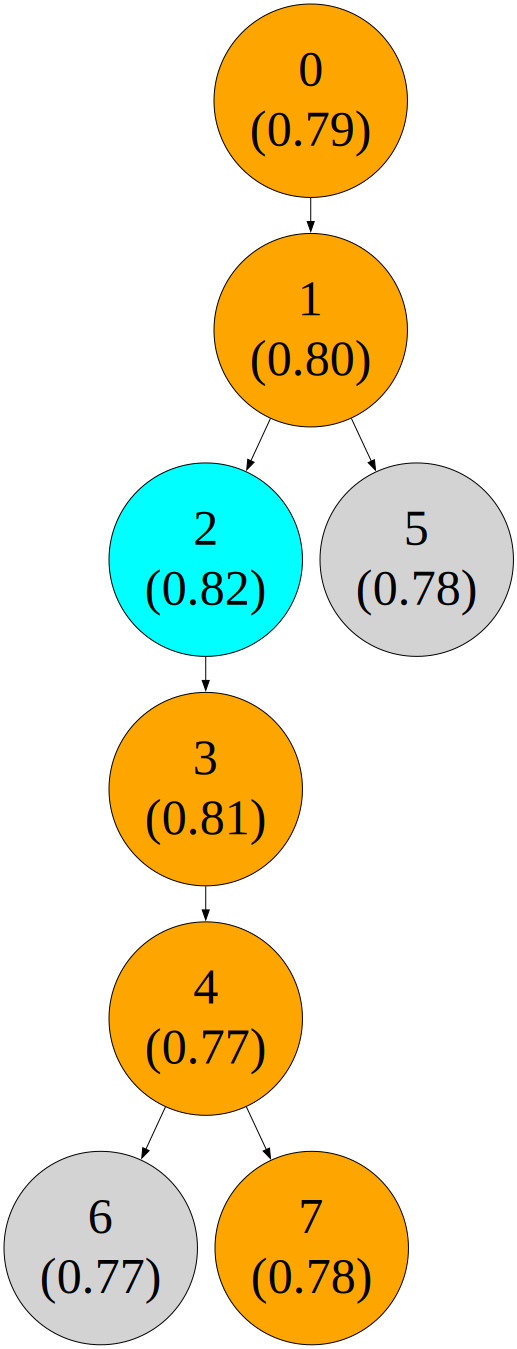

In [32]:
from IPython.display import SVG

SVG('../optimization_results/graphviz_dspy.svg')

In [33]:
result.best_candidate

{'instructions': 'Task: Classify a facility support email. Read the Subject and Body and output exactly one JSON object with: urgency, sentiment, categories.\n\nOutput requirements\n- Produce exactly one result with the three fields: urgency, sentiment, categories. Do not output explanations or multiple results.\n- categories must be a list of one or more strings from the taxonomy below (multi-label). Do not invent new labels.\n- Base decisions on the concrete content of the email. Ignore greetings/closings and boilerplate when judging tone and intent, but include them in the input text.\n\nUrgency (allowed values)\n- high: Immediate safety hazard or critical outage. Triggers include active fire/smoke, smell of gas, electrical sparking, elevator entrapment, security breach in progress, major/active water leak or flooding, building-wide HVAC or power outage impacting operations.\n- medium: Non-emergency but action should be taken soon. Includes time-bound requests, requests to schedule 

In [46]:
from gepadantic.signature_agent import SignatureAgent


signature_agent = SignatureAgent(
    test_agent,
    input_type=EmailInput,
)

In [47]:
async def evaluate_single_instance(data_inst):
    """Evaluate a single test instance."""
    
    with result.apply_best_to(agent=signature_agent, input_type=EmailInput):
        response = await signature_agent.run_signature(
            data_inst.input, 
        )
        output = RolloutOutput(
            result=response.output,
            success=True,
        )
        score = metric(data_inst, output)
    return score

async def evaluate_test_set_parallel():
    """Evaluate the test set with parallel execution."""
    # Create all tasks
    tasks = [
        evaluate_single_instance(test_set[i]) 
        for i in range(len(test_set))
    ]
    
    # Run all tasks concurrently
    scores = await asyncio.gather(*tasks)
    return scores


optimized_test_scores = await evaluate_test_set_parallel()

print(f"Optimized test score: {np.mean(optimized_test_scores)}")

TypeError: Expected signature of type EmailInput, got EmailInput

* Helper to create new models based on a candidate config

In [36]:
from gepadantic import apply_candidate_to_signature_model, apply_candidate_to_tool_model

EmailInput = apply_candidate_to_signature_model(EmailInput, result.best_candidate)

FacilitySupportAnalyzer = apply_candidate_to_tool_model(FacilitySupportAnalyzer, result.best_candidate)

In [37]:
EmailInput.model_json_schema()

{'description': 'Input model for facility support email classification. Provide a single string that contains the full raw email text (Subject and Body). The classifier will infer urgency, sentiment, and categories from this text. Include the Subject line and the complete Body exactly as received.',
 'properties': {'input': {'description': 'The full email content to classify, including the Subject line and Body as plain text in one string. Preserve original wording (including greetings/closings); do not add commentary or metadata.',
   'title': 'Input',
   'type': 'string'}},
 'required': ['input'],
 'title': 'EmailInput',
 'type': 'object'}

In [38]:
FacilitySupportAnalyzer.model_json_schema()

{'description': 'Analyze a facility support email and return exactly one JSON result with fields: urgency (high|medium|low), sentiment (positive|neutral|negative), and categories (list of allowed taxonomy labels). Use the urgency/sentiment rules and taxonomy precisely. Select all applicable categories from the list only; do not invent labels. Output a single JSON object and nothing else.',
 'properties': {'urgency': {'description': 'Urgency level of the request. Allowed values: high, medium, low.\nDecision rules:\n- high: Immediate hazard or critical outage (e.g., fire/smoke, gas smell, electrical sparking, elevator entrapment, security incident in progress, flooding/major active leak, building-wide power/HVAC outage affecting operations).\n- medium: Non-emergency but action requested soon; requests to schedule technician/inspection/assessment; issues affecting safety/compliance/service quality; time-bound requests; phrasing like “at your earliest convenience” or “to prevent complicati

* Or, we could just update the code

In [38]:
class EmailInput(BaseModel):
    """\
Schema: EmailInput has one field, input (str), which is the raw email text—Subject plus body—to classify into urgency, sentiment, \
and categories using the rules above."""
    
    input: str = Field(description="""\
Raw email content (Subject + body) as received. Consider the Subject for urgency cues. Ignore placeholders like [Sender]/[Receiver] and \
signatures/disclaimers; focus on the described issues, tone, and explicit requests. Extract signals of urgency, tone markers, \
and map content to the allowed categories only.
""")

In [39]:
class FacilitySupportAnalyzer(BaseModel):
    """\
Return a single JSON classification for the facility support email with keys: urgency (high/medium/low), \
sentiment (positive/neutral/negative), and categories (array of allowed labels). Do not include any extra keys or text."""
    
    urgency: Literal['low', 'medium', 'high'] = Field(description="""\
One of: high, medium, low.
- High: Explicit urgent/immediate/escalation language OR current safety/security hazard \
OR critical service disruption (e.g., power outage, gas leak/smell, active flooding/burst pipe, sparking/electrical hazard, \
elevator entrapment, active security breach). Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days/this week/soon) or an active but non‑hazard issue affecting comfort/operations (e.g., minor/contained \
leak, HVAC performance decline, routine follow‑up needed). Phrases like “as soon as possible,” “sooner rather than later,” or “earliest convenience” \
when an active issue exists ⇒ medium.
- Low: Routine inquiry or flexible scheduling with no active issue or disruption.""")
    
    sentiment: Literal['positive', 'neutral', 'negative'] = Field(description="""\
One of: positive, neutral, negative. Judge by tone, not issue presence.
- Positive: Appreciative/praising/polite warmth/confident language (e.g., thanks, appreciate, fantastic).
- Neutral: Factual/matter‑of‑fact or politely reporting an issue without clear dissatisfaction.
- Negative: Expressed dissatisfaction, frustration, disappointment, complaints about slow/poor service, or threats to escalate.""")
    
    categories: list[Literal[
        "emergency_repair_services", 
        "routine_maintenance_requests", 
        "quality_and_safety_concerns", 
        "specialized_cleaning_services", 
        "general_inquiries", 
        "sustainability_and_environmental_practices", 
        "training_and_support_requests", 
        "cleaning_services_scheduling", 
        "customer_feedback_and_complaints", 
        "facility_management_issues"]] = Field(description="""\
Array of strings. Choose any that apply from this controlled list only:
- quality_and_safety_concerns: Safety, hygiene/sanitation, cleanliness standards, compliance risk, or service quality/QA concerns (missed checks, protocol \
lapses, oversight impacting quality/safety).
- routine_maintenance_requests: Recurring/non‑acute maintenance (HVAC comfort/performance, minor leaks/plumbing, routine inspection, maintenance follow‑ups). \
If tied to missed checks/standards, also add quality_and_safety_concerns.
- customer_feedback_and_complaints: Dissatisfaction, oversight/service complaints, slow responses, escalation requests—even if politely phrased.
- specialized_cleaning_services: Deep/specialized cleaning (carpets, windows, floor care/waxing, high‑dusting) or explicit inquiries about cleaning services/practices.
- cleaning_services_scheduling: Scheduling or rescheduling a cleaning service.
- facility_management_issues: Coordination/operations/policy topics (space utilization, access control/badges, security measures/staffing, vendor governance). \
Not for specific equipment repair or a technician’s missed maintenance.
- emergency_repair_services: Immediate repair dispatch for critical failure/hazard (burst pipe/active flooding, power outage, gas leak/smell, \
sparking/electrical hazard, elevator entrapment).
- general_inquiries: Exploratory/informational questions about services/capabilities with no specific incident/work order.
- training_and_support_requests: Requests for training, SOPs, manuals, or support programs for in‑house teams.
- sustainability_and_environmental_practices: Sustainability, eco‑friendly/green cleaning, energy efficiency inquiries.""")